# Visual Material Recognition

### EDA

This notebook contains explanatory data analysis for visual material recognition paper. <br>
The goal is to predict hardness of the material based on the image of its microstructure. <br>

### Paths

In [1]:
import sys

root_path = ".."  # top-level of the repository

sys.path.append(root_path)

### Setup

In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from src.metrics import regression_report

In [3]:
sns.set()
plt.rcParams["figure.figsize"] = (16, 10)

# Data

In [4]:
mesurements_df = pd.read_csv("../data/measurements.csv")
mesurements_df.head(3)

,Sample,Hardness,File,Location,DELETED
0,1-101-1,115.0,data/images/1-101.jpg,top-left,TO DELETE
1,1-101-2,129.9,data/images/1-101.jpg,top-right,NaN
2,1-101-3,130.0,data/images/1-101.jpg,bottom-right,TO DELETE


Discard deleted images

In [5]:
pd.concat(
    [
        mesurements_df["DELETED"].notna().value_counts(),
        mesurements_df["DELETED"].notna().value_counts(normalize=True),
    ],
    axis=1
)

,DELETED,DELETED
False,987,0.856771
True,165,0.143229


In [6]:
mesurements_df = mesurements_df.drop(mesurements_df.loc[mesurements_df["DELETED"].notna()].index)  # drop values marked as DELETED or TO DELETE
mesurements_df = mesurements_df.drop(columns="DELETED")  # drop column

mesurements_df.head()

,Sample,Hardness,File,Location
1,1-101-2,129.9,data/images/1-101.jpg,top-right
3,1-101-4,130.0,data/images/1-101.jpg,bottom-left
5,1-102-2,137.6,data/images/1-102.jpg,top-right
7,1-102-4,127.8,data/images/1-102.jpg,bottom-left
9,1-103-2,140.0,data/images/1-103.jpg,top-right


Measurments file contains 4 columns:
* Sample label
* Measured hardness
* Path to image file of given sample
* Measurement location

In [7]:
mesurements_df["Hardness"].describe().apply(lambda value: f"{value:.2f}").to_frame()

,Hardness
count,986.00
mean,137.40
std,8.44
min,101.00
25%,132.72
50%,138.60
75%,142.70
max,176.10


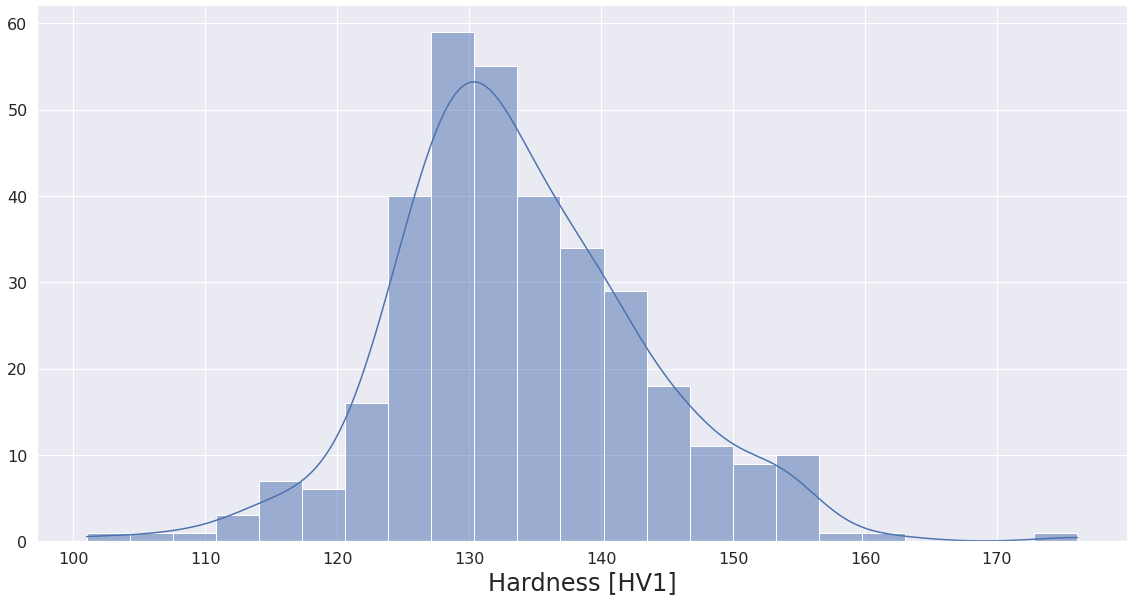

In [33]:
series_1_2_values = mesurements_df.loc[(mesurements_df["Sample"].str.startswith("1")) | (mesurements_df["Sample"].str.startswith("2"))]
_ = sns.displot(series_1_2_values["Hardness"].values, kde=True, aspect=2, height=8)
_ = plt.xlabel("Hardness [HV1]", fontsize=24)
_ = plt.ylabel("")
_ = plt.xticks(fontsize=16)
_ = plt.yticks(fontsize=16)
_ = plt.savefig("../data/plots/series-1-2-hardness-distribution.png", bbox_inches="tight")

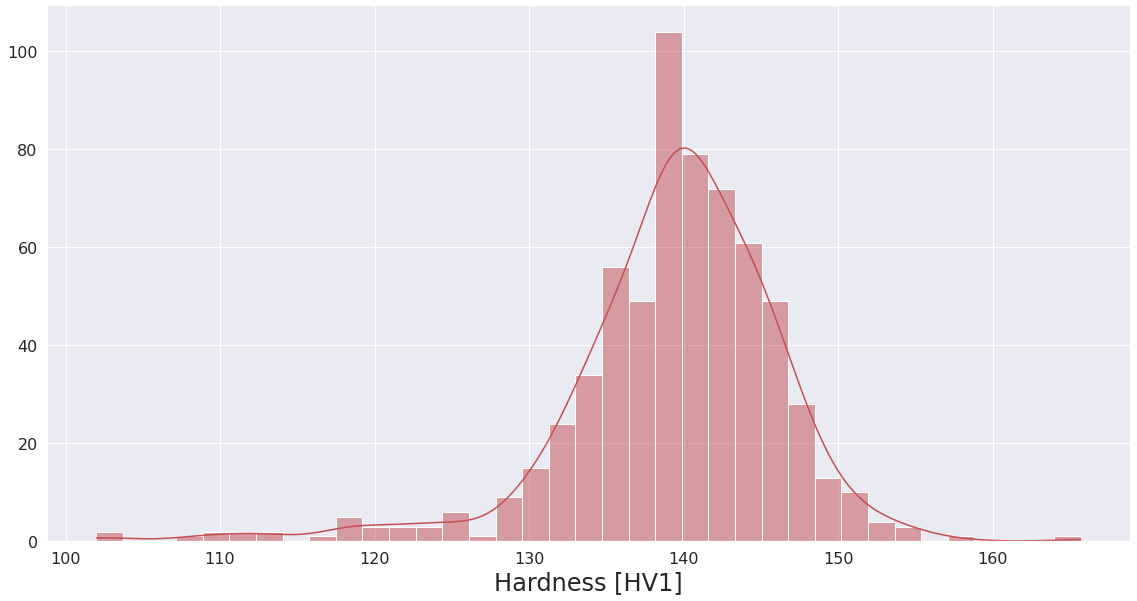

In [34]:
series_3_values = mesurements_df.loc[(mesurements_df["Sample"].str.startswith("3"))]
_ = sns.displot(series_3_values["Hardness"].values, color="r", kde=True, aspect=2, height=8)
_ = plt.xlabel("Hardness [HV1]", fontsize=24)
_ = plt.ylabel("")
_ = plt.xticks(fontsize=16)
_ = plt.yticks(fontsize=16)
_ = plt.savefig("../data/plots/series-3-hardness-distribution.png", bbox_inches="tight")

# Example

In [86]:
def load_and_display(path):
    """Util function for EDA purpose"""
    image = io.imread(path)
    io.imshow(image)
    
def sample_one(column):
    """Samples one element from pandas Series"""
    return column.sample(1).tolist()[0]

In [87]:
# map path to relative
mesurements_df["File"] = mesurements_df["File"].apply(lambda path: os.path.join("..", path))

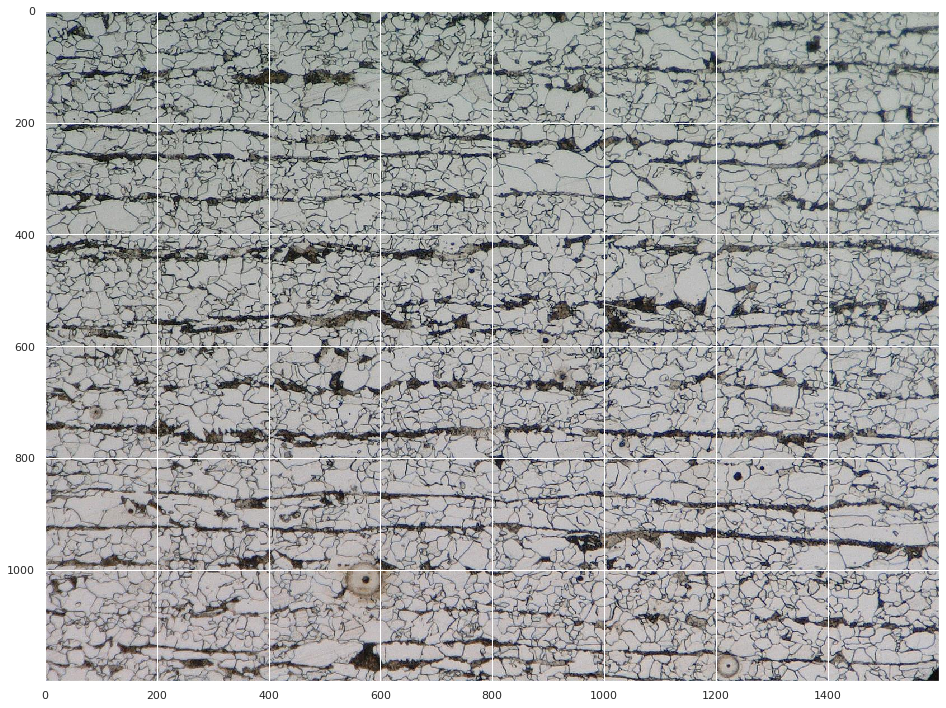

In [89]:
load_and_display(sample_one(mesurements_df["File"]))

# Split Data

In [35]:
# drop the image location code from sample labels
mesurements_df["Code"] = mesurements_df["Sample"].apply(lambda sample: "-".join(sample.split("-")[:-1]))

In [36]:
# the number of unique material samples measured
mesurements_df["Code"].nunique()

287

Chose sample to be left-out entirely from the dataset.

In [57]:
test_samples = pd.Series(mesurements_df["Code"].unique()).sample(frac=0.15)
len(test_samples), len(mesurements_df.loc[mesurements_df["Code"].isin(test_samples)])

(43, 152)

Create column for Group, it will contain values: `TEST`, `VAL` and `TRAIN`

In [58]:
mesurements_df["Group"] = pd.NA

Mark selected samples as test

In [59]:
mesurements_df.loc[mesurements_df.loc[mesurements_df["Code"].isin(test_samples)].index, "Group"] = "TEST"

Split the rest of data into train and validation parts

In [61]:
train_index, validation_index = train_test_split(mesurements_df.drop(mesurements_df.loc[mesurements_df["Group"] == "TEST"].index).index, test_size=0.15)
len(train_index), len(validation_index)

(709, 126)

Assign `Group` values

In [62]:
mesurements_df.loc[mesurements_df.loc[mesurements_df.index.isin(train_index)].index, "Group"] = "TRAIN"
mesurements_df.loc[mesurements_df.loc[mesurements_df.index.isin(validation_index)].index, "Group"] = "VAL"

Total number of samples in different groups

In [63]:
pd.concat(
    [
        mesurements_df["Group"].value_counts(),
        mesurements_df["Group"].value_counts(normalize=True),
    ],
    axis=1
)

,Group,Group
TRAIN,709,0.718338
TEST,152,0.154002
VAL,126,0.127660


Save file as `dataset.csv`

In [64]:
mesurements_df.to_csv("../data/dataset.csv", index=False)